In [1]:
import pandas as pd
import sys
import datetime
import matplotlib.pylab as plt
import numpy as np
from math import log, floor, ceil
from typing import Dict

In [2]:
START_DATE = datetime.date(2020,2,24)

In [3]:
def create_filename(day_str: str) -> str:
    return ('../dati-province/dpc-covid19-ita-province-' + day_str + '.csv')

In [4]:
def handle_Toscana_20200326_error(cases: Dict[str, int]) -> Dict[str, int]:
    cases['20200327'] = cases['20200326'] + floor((cases['20200328'] - cases['20200326'])/2)
    cases['20200328'] = cases['20200327'] + ceil((cases['20200328'] - cases['20200326'])/2)
    return cases

In [5]:
def calculate_and_create_chart_for_province(start_date: datetime.date, province: str):
    day = start_date
    cases: Dict[str,int] = {}
    while day<=datetime.date.today():
        day_str: str = day.strftime("%Y%m%d")
        filename: str = create_filename(day_str)
        df: pd.DataFrame = pd.read_csv(filename, encoding = "ISO-8859-1")
        cases[day_str] = int(df[df["denominazione_provincia"]==province]["totale_casi"])
        day: datetime.date = day + datetime.timedelta(days = 1)
    
    if df[df["denominazione_provincia"]==province]["denominazione_regione"].any()=='Toscana':
        cases = handle_Toscana_20200326_error(cases)
    
    cases_df: pd.DataFrame = pd.DataFrame.from_dict(cases, orient='index')
    cases_df = cases_df.reset_index()
    cases_df = cases_df.rename(columns={"index": "Day", 0: "Cases"})
    
    cases_df_today = cases_df[cases_df["Day"]==datetime.date.today().strftime("%Y%m%d")]["Cases"].sum()
    print("Total cases per 1000 inhabitants up to today:", round(calculate_cases_to_inhabitants_ratio(cases_df_today, province),4))
    calculate_stats(cases_df)

    x = cases_df.index
    y = cases_df["Cases"]
    plt.scatter(x, y)

    z = np.polyfit(x, y, 3)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    plt.grid()
    plt.yscale("log")
    plt.show()
    return

In [6]:

def calculate_and_create_chart_for_region(start_date: datetime.date, region: str):
    day: datetime.date = start_date
    cases: Dict[str, int] = {}
    while day<=datetime.date.today():
        day_str: str = day.strftime("%Y%m%d")
        filename: str = create_filename(day_str)
        df: pd.DataFrame = pd.read_csv(filename, encoding = "ISO-8859-1")
        cases[day_str] = int(df[(df["denominazione_regione"]==region)&(df["denominazione_provincia"]!='In fase di definizione/aggiornamento')]["totale_casi"].sum())
        day: datetime.date = day + datetime.timedelta(days = 1)
        
    if region == 'Toscana':
        cases = handle_Toscana_20200326_error(cases)

    cases_df = pd.DataFrame.from_dict(cases, orient='index')
    cases_df = cases_df.reset_index()
    cases_df = cases_df.rename(columns={"index": "Day", 0: "Cases"})
    
    calculate_stats(cases_df)

    x = cases_df.index
    y = cases_df["Cases"]
    plt.scatter(x, y)

    z = np.polyfit(x, y, 3)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    plt.grid()
    plt.yscale("log")
    plt.show()
    return

In [7]:
def calculate_and_create_chart_for_Italy(start_date: datetime.date):
    day = start_date
    cases = {}
    while day<=datetime.date.today():
        day_str: str = day.strftime("%Y%m%d")
        filename: str = create_filename(day_str)
        df: pd.DataFrame = pd.read_csv(filename, encoding = "ISO-8859-1")
        cases[day_str] = int(df[df["denominazione_provincia"]!='In fase di definizione/aggiornamento']["totale_casi"].sum())
        day: datetime.date = day + datetime.timedelta(days = 1)

    cases_df: pd.DataFrame = pd.DataFrame.from_dict(cases, orient='index')
    cases_df = cases_df.reset_index()
    cases_df = cases_df.rename(columns={"index": "Day", 0: "Cases"})
    
    calculate_stats(cases_df)

    x = cases_df.index
    y = cases_df["Cases"]
    plt.scatter(x, y)

    z = np.polyfit(x, y, 3)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    plt.grid()
    plt.yscale("log")
    plt.show()
    return

In [8]:
def calculate_stats(cases_df):
    cases_df_today = cases_df[cases_df["Day"]==datetime.date.today().strftime("%Y%m%d")]["Cases"].sum()
    cases_df_yesterday = cases_df[cases_df["Day"]==(datetime.date.today()- datetime.timedelta(days = 1)).strftime("%Y%m%d")]["Cases"].sum()
    cases_df_five_days_ago = cases_df[cases_df["Day"]==(datetime.date.today()- datetime.timedelta(days = 5)).strftime("%Y%m%d")]["Cases"].sum()
    cases_df_six_days_ago = cases_df[cases_df["Day"]==(datetime.date.today()- datetime.timedelta(days = 6)).strftime("%Y%m%d")]["Cases"].sum()
    print("Total cases up to today:", cases_df_today)
    print("New cases registered today:", cases_df_today-cases_df_yesterday)
    if int(cases_df_yesterday) != 0:
        print("New cases registered today in %:", round((cases_df_today-cases_df_yesterday)/cases_df_yesterday*100,2))

    print("Doubling time in the last five days:", round(calculate_doubling_time_in_the_last_five_days(cases_df_today, cases_df_five_days_ago), 1))
    print("Doubling time yesterday:", round(calculate_doubling_time_in_the_last_five_days(cases_df_yesterday, cases_df_six_days_ago), 1))
    print("Trend of new cases (in %) in the last 5 days:", round((cases_df_today-cases_df_five_days_ago)/cases_df_five_days_ago*100,2))
    
    return

In [9]:
def calculate_doubling_time_in_the_last_five_days(cases_df_today, cases_df_five_days_ago):
    if cases_df_five_days_ago ==0:
        return np.nan
    log_result = log(cases_df_today/cases_df_five_days_ago)
    if log_result != 0:
        return (5*log(2))/(log_result)
    else:
        return np.nan
    

In [10]:
def calculate_cases_to_inhabitants_ratio(cases: int, province: str) -> float:
    df_province: pd.DataFrame = pd.read_csv("../general/province.csv")
    inhabitants = df_province[df_province["Provincia"]==province]["Residenti"].str.replace('.', '', regex=True).sum()
    return int(cases)/int(inhabitants)*1000

# Casi di COVID-19 in Italia - COVID-19 cases in Italy

Total cases up to today: 120611
New cases registered today: 4597
New cases registered today in %: 3.96
Doubling time in the last five days: 17.2
Doubling time yesterday: 17.1
Trend of new cases (in %) in the last 5 days: 22.28


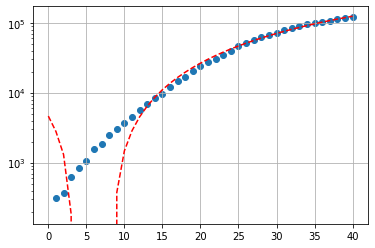

In [11]:
calculate_and_create_chart_for_Italy(START_DATE)

# Casi di COVID-19 in Abruzzo - COVID-19 cases in Abruzzo

Total cases up to today: 1628
New cases registered today: 65
New cases registered today in %: 4.16
Doubling time in the last five days: 18.1
Doubling time yesterday: 18.3
Trend of new cases (in %) in the last 5 days: 21.04


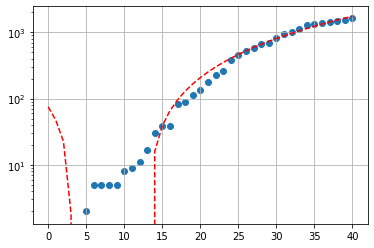

In [12]:
calculate_and_create_chart_for_region(START_DATE, 'Abruzzo')

## Chieti

Total cases per 1000 inhabitants up to today: 0.8146
Total cases up to today: 317
New cases registered today: 7
New cases registered today in %: 2.26
Doubling time in the last five days: 23.2
Doubling time yesterday: 22.6
Trend of new cases (in %) in the last 5 days: 16.12


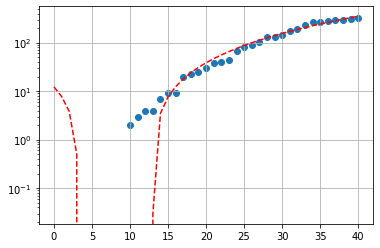

In [13]:
calculate_and_create_chart_for_province(START_DATE, 'Chieti')

## L'Aquila

Total cases per 1000 inhabitants up to today: 0.5763
Total cases up to today: 174
New cases registered today: 8
New cases registered today in %: 4.82
Doubling time in the last five days: 8.4
Doubling time yesterday: 7.0
Trend of new cases (in %) in the last 5 days: 51.3


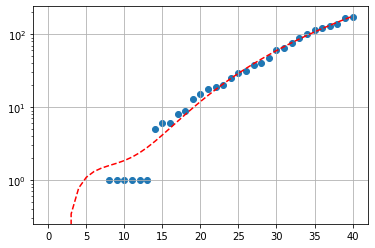

In [14]:
calculate_and_create_chart_for_province(START_DATE, "L'Aquila")

## Pescara

Total cases per 1000 inhabitants up to today: 2.1786
Total cases up to today: 700
New cases registered today: 31
New cases registered today in %: 4.63
Doubling time in the last five days: 21.1
Doubling time yesterday: 23.2
Trend of new cases (in %) in the last 5 days: 17.85


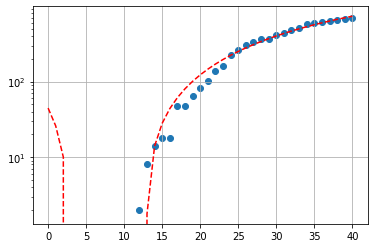

In [15]:
calculate_and_create_chart_for_province(START_DATE, 'Pescara')

## Teramo

Total cases per 1000 inhabitants up to today: 1.4103
Total cases up to today: 437
New cases registered today: 19
New cases registered today in %: 4.55
Doubling time in the last five days: 18.7
Doubling time yesterday: 19.5
Trend of new cases (in %) in the last 5 days: 20.39


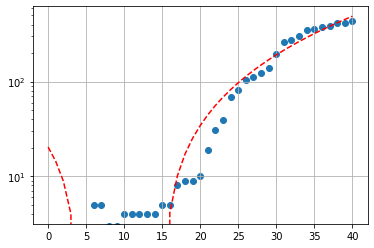

In [16]:
calculate_and_create_chart_for_province(START_DATE, 'Teramo')

# Casi di COVID-19 in Basilicata - COVID-19 cases in Basilicata

Total cases up to today: 264
New cases registered today: 3
New cases registered today in %: 1.15
Doubling time in the last five days: 16.5
Doubling time yesterday: 13.5
Trend of new cases (in %) in the last 5 days: 23.36


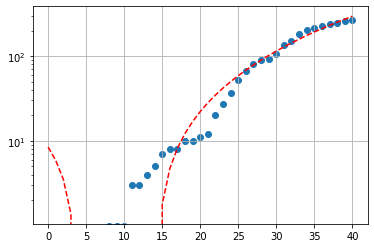

In [17]:
calculate_and_create_chart_for_region(START_DATE, 'Basilicata')

## Matera

Total cases per 1000 inhabitants up to today: 0.626
Total cases up to today: 125
New cases registered today: 1
New cases registered today in %: 0.81
Doubling time in the last five days: 11.3
Doubling time yesterday: 8.9
Trend of new cases (in %) in the last 5 days: 35.87


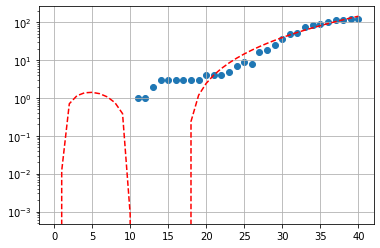

In [18]:
calculate_and_create_chart_for_province(START_DATE, 'Matera')

## Potenza

Total cases per 1000 inhabitants up to today: 0.375
Total cases up to today: 139
New cases registered today: 2
New cases registered today in %: 1.46
Doubling time in the last five days: 26.6
Doubling time yesterday: 23.2
Trend of new cases (in %) in the last 5 days: 13.93


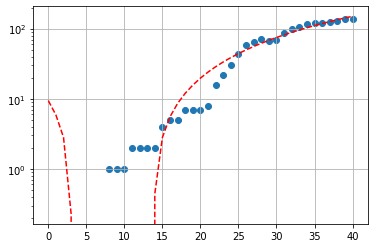

In [19]:
calculate_and_create_chart_for_province(START_DATE, 'Potenza')

# Casi di COVID-19 nella Provincia Autonoma di Bolzano - COVID-19 cases in Autonomous Province of Bolzano

Total cases up to today: 1592
New cases registered today: 33
New cases registered today in %: 2.12
Doubling time in the last five days: 18.9
Doubling time yesterday: 13.9
Trend of new cases (in %) in the last 5 days: 20.15


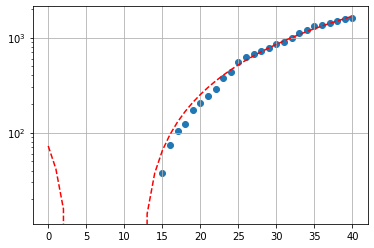

In [20]:
calculate_and_create_chart_for_region(START_DATE, 'P.A. Bolzano')

# Casi di COVID-19 in Calabria - COVID-19 cases in Calabria

Total cases up to today: 739
New cases registered today: 8
New cases registered today in %: 1.09
Doubling time in the last five days: 25.5
Doubling time yesterday: 19.5
Trend of new cases (in %) in the last 5 days: 14.57


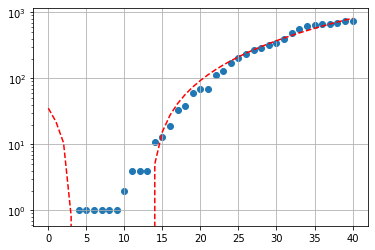

In [21]:
calculate_and_create_chart_for_region(START_DATE, 'Calabria')

## Catanzaro

Total cases per 1000 inhabitants up to today: 0.414
Total cases up to today: 150
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 30.7
Doubling time yesterday: 17.5
Trend of new cases (in %) in the last 5 days: 11.94


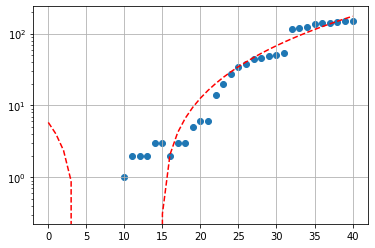

In [22]:
calculate_and_create_chart_for_province(START_DATE, 'Catanzaro')

## Cosenza

Total cases per 1000 inhabitants up to today: 0.2866
Total cases up to today: 204
New cases registered today: 1
New cases registered today in %: 0.49
Doubling time in the last five days: 33.6
Doubling time yesterday: 20.2
Trend of new cases (in %) in the last 5 days: 10.87


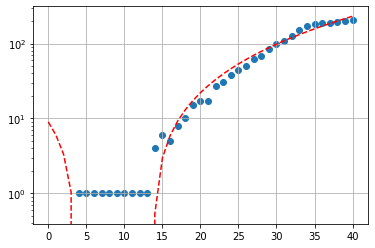

In [23]:
calculate_and_create_chart_for_province(START_DATE, 'Cosenza')

## Crotone

Total cases per 1000 inhabitants up to today: 0.6038
Total cases up to today: 106
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 26.5
Doubling time yesterday: 21.2
Trend of new cases (in %) in the last 5 days: 13.98


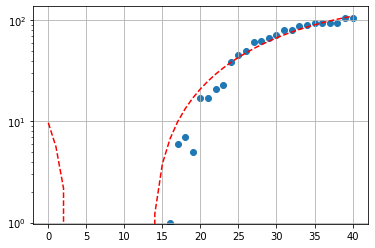

In [24]:
calculate_and_create_chart_for_province(START_DATE, 'Crotone')

## Reggio di Calabria

Total cases per 1000 inhabitants up to today: 0.4008
Total cases up to today: 222
New cases registered today: 4
New cases registered today in %: 1.83
Doubling time in the last five days: 22.3
Doubling time yesterday: 24.3
Trend of new cases (in %) in the last 5 days: 16.84


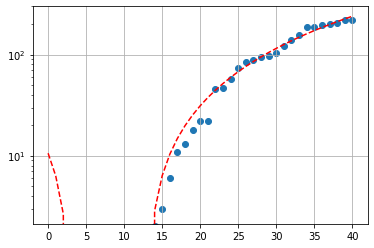

In [25]:
calculate_and_create_chart_for_province(START_DATE, 'Reggio di Calabria')

## Vibo Valentia

Total cases per 1000 inhabitants up to today: 0.3527
Total cases up to today: 57
New cases registered today: 3
New cases registered today in %: 5.56
Doubling time in the last five days: 13.4
Doubling time yesterday: 10.6
Trend of new cases (in %) in the last 5 days: 29.55


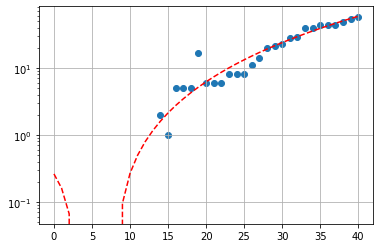

In [26]:
calculate_and_create_chart_for_province(START_DATE, 'Vibo Valentia')

# Casi di COVID-19 in Campania - COVID-19 cases in Campania

Total cases up to today: 2640
New cases registered today: 123
New cases registered today in %: 4.89
Doubling time in the last five days: 9.4
Doubling time yesterday: 8.2
Trend of new cases (in %) in the last 5 days: 44.66


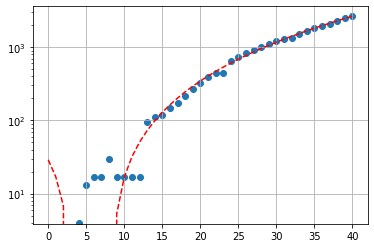

In [27]:
calculate_and_create_chart_for_region(START_DATE, 'Campania')

## Avellino

Total cases per 1000 inhabitants up to today: 0.8288
Total cases up to today: 351
New cases registered today: 11
New cases registered today in %: 3.24
Doubling time in the last five days: 7.4
Doubling time yesterday: 7.1
Trend of new cases (in %) in the last 5 days: 59.55


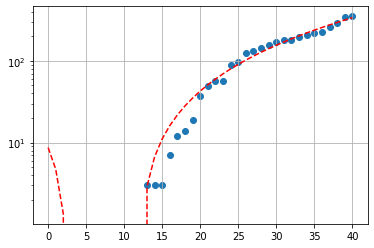

In [28]:
calculate_and_create_chart_for_province(START_DATE, 'Avellino')

## Benevento

Total cases per 1000 inhabitants up to today: 0.3075
Total cases up to today: 86
New cases registered today: 1
New cases registered today in %: 1.18
Doubling time in the last five days: 16.8
Doubling time yesterday: 2.5
Trend of new cases (in %) in the last 5 days: 22.86


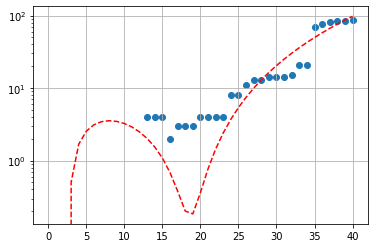

In [29]:
calculate_and_create_chart_for_province(START_DATE, 'Benevento')

## Caserta

Total cases per 1000 inhabitants up to today: 0.3019
Total cases up to today: 279
New cases registered today: 15
New cases registered today in %: 5.68
Doubling time in the last five days: 11.4
Doubling time yesterday: 11.8
Trend of new cases (in %) in the last 5 days: 35.44


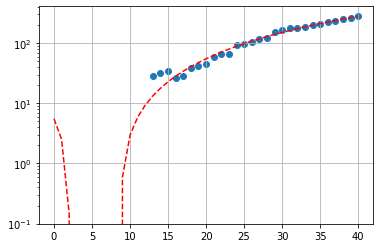

In [30]:
calculate_and_create_chart_for_province(START_DATE, 'Caserta')

## Napoli

Total cases per 1000 inhabitants up to today: 0.4821
Total cases up to today: 1498
New cases registered today: 70
New cases registered today in %: 4.9
Doubling time in the last five days: 8.4
Doubling time yesterday: 7.5
Trend of new cases (in %) in the last 5 days: 51.16


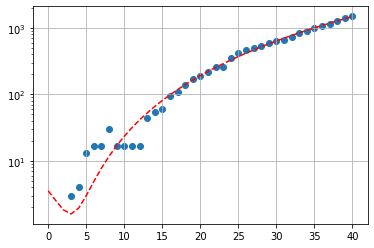

In [31]:
calculate_and_create_chart_for_province(START_DATE, 'Napoli')

## Salerno

Total cases per 1000 inhabitants up to today: 0.3856
Total cases up to today: 426
New cases registered today: 26
New cases registered today in %: 6.5
Doubling time in the last five days: 15.0
Doubling time yesterday: 16.2
Trend of new cases (in %) in the last 5 days: 26.04


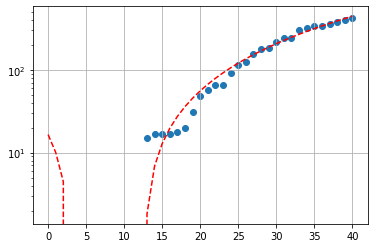

In [32]:
calculate_and_create_chart_for_province(START_DATE, 'Salerno')

# Casi di COVID-19 in Emilia Romagna - COVID-19 cases in Emilia Romagna

Total cases up to today: 0
New cases registered today: 0
Doubling time in the last five days: nan
Doubling time yesterday: nan
Trend of new cases (in %) in the last 5 days: nan


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]


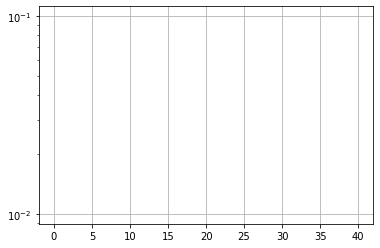

In [33]:
calculate_and_create_chart_for_region(START_DATE, 'Emilia Romagna')

## Bologna

Total cases per 1000 inhabitants up to today: 2.4068
Total cases up to today: 2429
New cases registered today: 90
New cases registered today in %: 3.85
Doubling time in the last five days: 13.3
Doubling time yesterday: 11.8
Trend of new cases (in %) in the last 5 days: 29.75


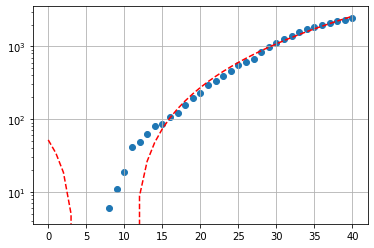

In [34]:
calculate_and_create_chart_for_province(START_DATE, 'Bologna')

## Ferrara

Total cases per 1000 inhabitants up to today: 1.3607
Total cases up to today: 474
New cases registered today: 106
New cases registered today in %: 28.8
Doubling time in the last five days: 7.9
Doubling time yesterday: 17.0
Trend of new cases (in %) in the last 5 days: 54.9


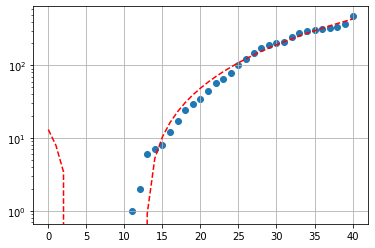

In [35]:
calculate_and_create_chart_for_province(START_DATE, 'Ferrara')

## Modena

Total cases per 1000 inhabitants up to today: 3.6398
Total cases up to today: 2551
New cases registered today: 53
New cases registered today in %: 2.12
Doubling time in the last five days: 19.6
Doubling time yesterday: 19.6
Trend of new cases (in %) in the last 5 days: 19.37


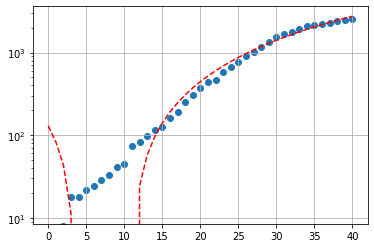

In [36]:
calculate_and_create_chart_for_province(START_DATE, 'Modena')

## Parma

Total cases per 1000 inhabitants up to today: 4.9031
Total cases up to today: 2201
New cases registered today: 118
New cases registered today in %: 5.66
Doubling time in the last five days: 20.5
Doubling time yesterday: 24.6
Trend of new cases (in %) in the last 5 days: 18.4


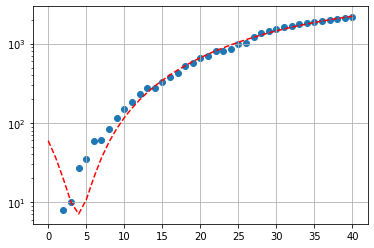

In [37]:
calculate_and_create_chart_for_province(START_DATE, 'Parma')

## Piacenza

Total cases per 1000 inhabitants up to today: 9.9108
Total cases up to today: 2842
New cases registered today: 31
New cases registered today in %: 1.1
Doubling time in the last five days: 28.4
Doubling time yesterday: 27.2
Trend of new cases (in %) in the last 5 days: 12.96


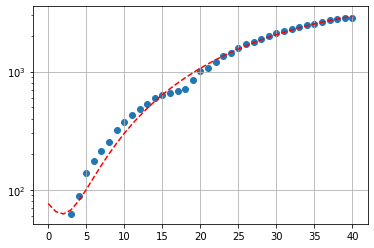

In [38]:
calculate_and_create_chart_for_province(START_DATE, 'Piacenza')

## Ravenna

Total cases per 1000 inhabitants up to today: 1.7577
Total cases up to today: 688
New cases registered today: 32
New cases registered today in %: 4.88
Doubling time in the last five days: 18.1
Doubling time yesterday: 20.3
Trend of new cases (in %) in the last 5 days: 21.13


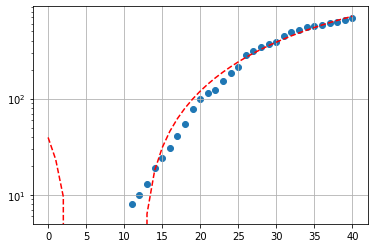

In [39]:
calculate_and_create_chart_for_province(START_DATE, 'Ravenna')

## Reggio nell'Emilia

Total cases per 1000 inhabitants up to today: 5.4612
Total cases up to today: 2908
New cases registered today: 108
New cases registered today in %: 3.86
Doubling time in the last five days: 12.6
Doubling time yesterday: 13.0
Trend of new cases (in %) in the last 5 days: 31.7


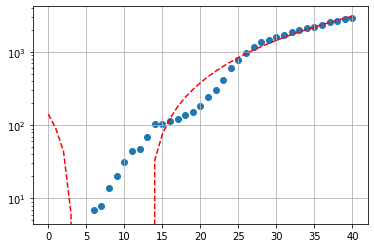

In [40]:
calculate_and_create_chart_for_province(START_DATE, "Reggio nell'Emilia")

## Rimini

Total cases per 1000 inhabitants up to today: 4.5222
Total cases up to today: 1523
New cases registered today: 12
New cases registered today in %: 0.79
Doubling time in the last five days: 35.7
Doubling time yesterday: 32.2
Trend of new cases (in %) in the last 5 days: 10.2


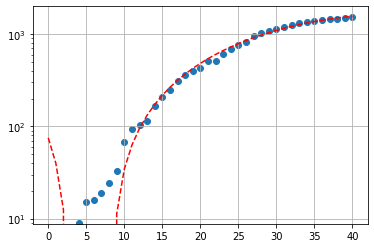

In [41]:
calculate_and_create_chart_for_province(START_DATE, 'Rimini')

# Casi di COVID-19 in Friuli Venezia Giulia - COVID-19 cases in Friuli Venezia Giulia

Total cases up to today: 1981
New cases registered today: 108
New cases registered today in %: 5.77
Doubling time in the last five days: 12.2
Doubling time yesterday: 14.3
Trend of new cases (in %) in the last 5 days: 32.77


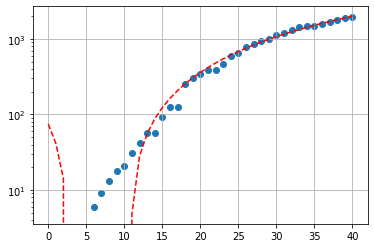

In [42]:
calculate_and_create_chart_for_region(START_DATE, 'Friuli Venezia Giulia')

## Gorizia

Total cases per 1000 inhabitants up to today: 0.8234
Total cases up to today: 115
New cases registered today: 4
New cases registered today in %: 3.6
Doubling time in the last five days: 14.8
Doubling time yesterday: 17.4
Trend of new cases (in %) in the last 5 days: 26.37


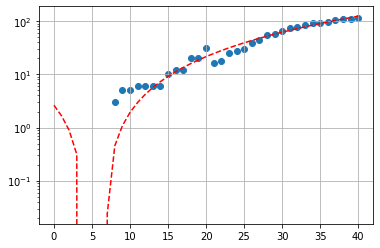

In [43]:
calculate_and_create_chart_for_province(START_DATE, 'Gorizia')

## Pordenone

Total cases per 1000 inhabitants up to today: 1.4773
Total cases up to today: 461
New cases registered today: 9
New cases registered today in %: 1.99
Doubling time in the last five days: 18.7
Doubling time yesterday: 16.9
Trend of new cases (in %) in the last 5 days: 20.37


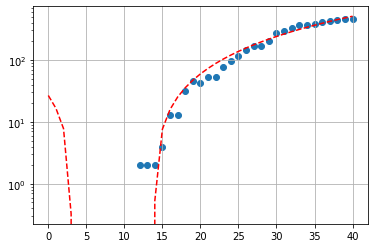

In [44]:
calculate_and_create_chart_for_province(START_DATE, 'Pordenone')

## Trieste

Total cases per 1000 inhabitants up to today: 2.774
Total cases up to today: 651
New cases registered today: 22
New cases registered today in %: 3.5
Doubling time in the last five days: 12.6
Doubling time yesterday: 12.4
Trend of new cases (in %) in the last 5 days: 31.78


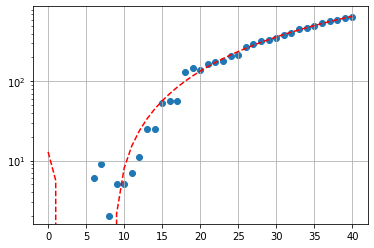

In [45]:
calculate_and_create_chart_for_province(START_DATE, 'Trieste')

## Udine

Total cases per 1000 inhabitants up to today: 1.4187
Total cases up to today: 754
New cases registered today: 73
New cases registered today in %: 10.72
Doubling time in the last five days: 9.5
Doubling time yesterday: 14.5
Trend of new cases (in %) in the last 5 days: 43.89


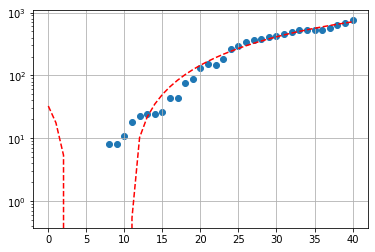

In [46]:
calculate_and_create_chart_for_province(START_DATE, 'Udine')

# Casi di COVID-19 nel Lazio - COVID-19 cases in Lazio

Total cases up to today: 3730
New cases registered today: 155
New cases registered today in %: 4.34
Doubling time in the last five days: 13.7
Doubling time yesterday: 12.2
Trend of new cases (in %) in the last 5 days: 28.71


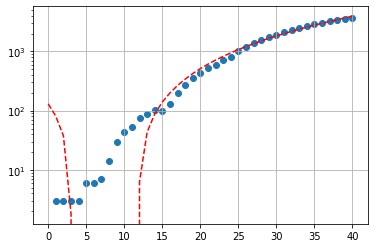

In [47]:
calculate_and_create_chart_for_region(START_DATE, 'Lazio')

## Frosinone

Total cases per 1000 inhabitants up to today: 0.7382
Total cases up to today: 364
New cases registered today: 10
New cases registered today in %: 2.82
Doubling time in the last five days: 15.2
Doubling time yesterday: 10.2
Trend of new cases (in %) in the last 5 days: 25.52


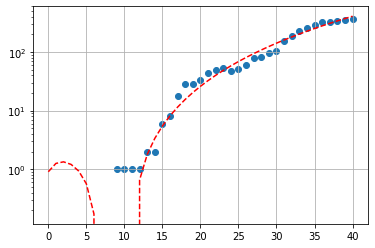

In [48]:
calculate_and_create_chart_for_province(START_DATE, 'Frosinone')

## Latina

Total cases per 1000 inhabitants up to today: 0.5531
Total cases up to today: 318
New cases registered today: 14
New cases registered today in %: 4.61
Doubling time in the last five days: 15.4
Doubling time yesterday: 14.4
Trend of new cases (in %) in the last 5 days: 25.2


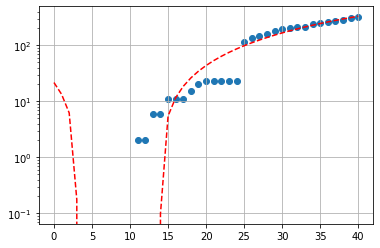

In [49]:
calculate_and_create_chart_for_province(START_DATE, 'Latina')

## Rieti

Total cases per 1000 inhabitants up to today: 1.1943
Total cases up to today: 188
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 5.9
Doubling time yesterday: 3.8
Trend of new cases (in %) in the last 5 days: 79.05


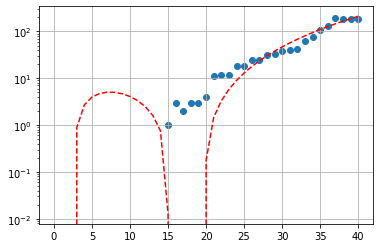

In [50]:
calculate_and_create_chart_for_province(START_DATE, 'Rieti')

## Roma

Total cases per 1000 inhabitants up to today: 0.6018
Total cases up to today: 2620
New cases registered today: 117
New cases registered today in %: 4.67
Doubling time in the last five days: 14.6
Doubling time yesterday: 13.7
Trend of new cases (in %) in the last 5 days: 26.69


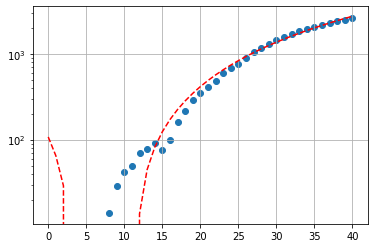

In [51]:
calculate_and_create_chart_for_province(START_DATE, 'Roma')

## Viterbo

Total cases per 1000 inhabitants up to today: 0.7523
Total cases up to today: 240
New cases registered today: 14
New cases registered today in %: 6.19
Doubling time in the last five days: 12.3
Doubling time yesterday: 14.9
Trend of new cases (in %) in the last 5 days: 32.6


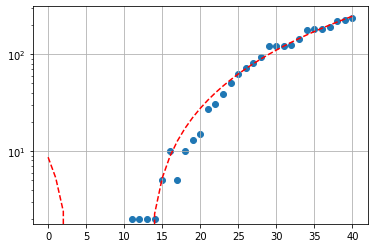

In [52]:
calculate_and_create_chart_for_province(START_DATE, 'Viterbo')

# Casi di COVID-19 in Liguria - COVID-19 cases in Liguria

Total cases up to today: 2138
New cases registered today: 148
New cases registered today in %: 7.44
Doubling time in the last five days: 19.8
Doubling time yesterday: 25.0
Trend of new cases (in %) in the last 5 days: 19.11


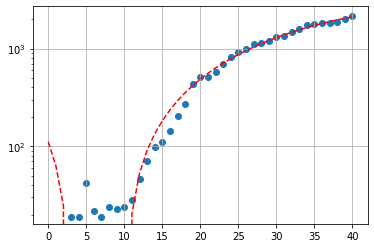

In [53]:
calculate_and_create_chart_for_region(START_DATE, 'Liguria')

## Genova

Total cases per 1000 inhabitants up to today: 1.5434
Total cases up to today: 1312
New cases registered today: 132
New cases registered today in %: 11.19
Doubling time in the last five days: 16.9
Doubling time yesterday: 24.8
Trend of new cases (in %) in the last 5 days: 22.73


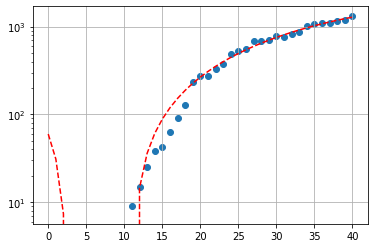

In [54]:
calculate_and_create_chart_for_province(START_DATE, 'Genova')

## Imperia

Total cases per 1000 inhabitants up to today: 1.0412
Total cases up to today: 224
New cases registered today: 1
New cases registered today in %: 0.45
Doubling time in the last five days: -42.6
Doubling time yesterday: -72.0
Trend of new cases (in %) in the last 5 days: -7.82


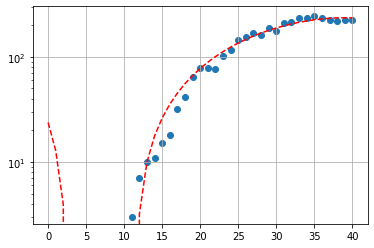

In [55]:
calculate_and_create_chart_for_province(START_DATE, 'Imperia')

## La Spezia

Total cases per 1000 inhabitants up to today: 1.5451
Total cases up to today: 341
New cases registered today: 18
New cases registered today in %: 5.57
Doubling time in the last five days: 9.2
Doubling time yesterday: 10.6
Trend of new cases (in %) in the last 5 days: 45.73


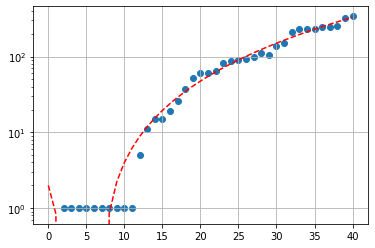

In [56]:
calculate_and_create_chart_for_province(START_DATE, 'La Spezia')

## Savona

Total cases per 1000 inhabitants up to today: 0.9341
Total cases up to today: 261
New cases registered today: -3
New cases registered today in %: -1.14
Doubling time in the last five days: 73.6
Doubling time yesterday: 34.8
Trend of new cases (in %) in the last 5 days: 4.82


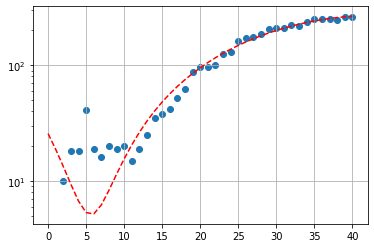

In [57]:
calculate_and_create_chart_for_province(START_DATE, 'Savona')

# Casi di COVID-19 in Lombardia - COVID-19 cases in Lombardy

Total cases up to today: 48052
New cases registered today: 1560
New cases registered today in %: 3.36
Doubling time in the last five days: 22.7
Doubling time yesterday: 23.5
Trend of new cases (in %) in the last 5 days: 16.48


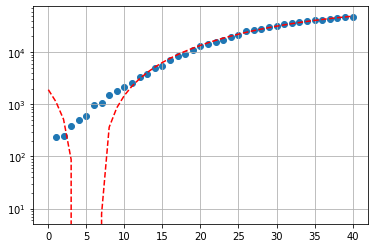

In [58]:
calculate_and_create_chart_for_region(START_DATE, 'Lombardia')

## Bergamo

Total cases per 1000 inhabitants up to today: 8.6384
Total cases up to today: 9588
New cases registered today: 273
New cases registered today in %: 2.93
Doubling time in the last five days: 34.2
Doubling time yesterday: 39.2
Trend of new cases (in %) in the last 5 days: 10.66


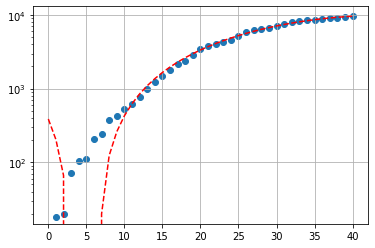

In [59]:
calculate_and_create_chart_for_province(START_DATE, 'Bergamo')

## Brescia

Total cases per 1000 inhabitants up to today: 7.2723
Total cases up to today: 9180
New cases registered today: 166
New cases registered today in %: 1.84
Doubling time in the last five days: 31.1
Doubling time yesterday: 29.4
Trend of new cases (in %) in the last 5 days: 11.77


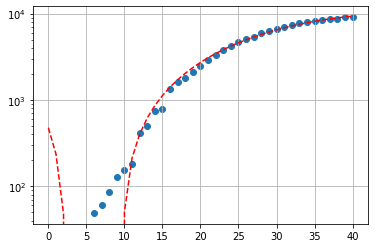

In [60]:
calculate_and_create_chart_for_province(START_DATE, 'Brescia')

## Como

Total cases per 1000 inhabitants up to today: 2.1976
Total cases up to today: 1319
New cases registered today: 63
New cases registered today in %: 5.02
Doubling time in the last five days: 15.9
Doubling time yesterday: 16.2
Trend of new cases (in %) in the last 5 days: 24.32


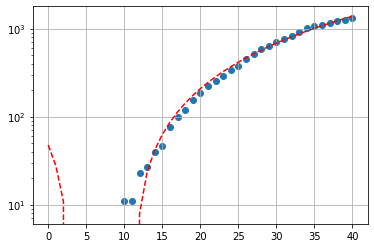

In [61]:
calculate_and_create_chart_for_province(START_DATE, 'Como')

## Cremona

Total cases per 1000 inhabitants up to today: 11.5585
Total cases up to today: 4154
New cases registered today: 57
New cases registered today in %: 1.39
Doubling time in the last five days: 37.6
Doubling time yesterday: 40.6
Trend of new cases (in %) in the last 5 days: 9.66


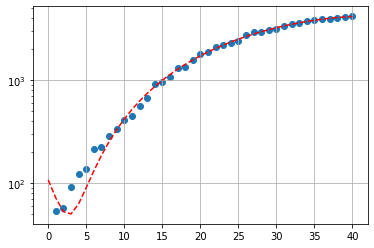

In [62]:
calculate_and_create_chart_for_province(START_DATE, 'Cremona')

## Lecco

Total cases per 1000 inhabitants up to today: 4.799
Total cases up to today: 1628
New cases registered today: 34
New cases registered today in %: 2.13
Doubling time in the last five days: 27.8
Doubling time yesterday: 24.2
Trend of new cases (in %) in the last 5 days: 13.29


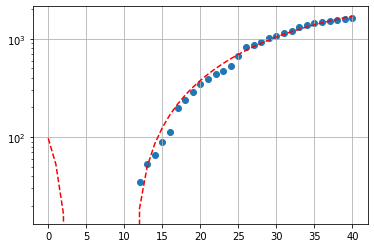

In [63]:
calculate_and_create_chart_for_province(START_DATE, 'Lecco')

## Lodi

Total cases per 1000 inhabitants up to today: 9.7585
Total cases up to today: 2238
New cases registered today: 24
New cases registered today in %: 1.08
Doubling time in the last five days: 49.6
Doubling time yesterday: 47.1
Trend of new cases (in %) in the last 5 days: 7.24


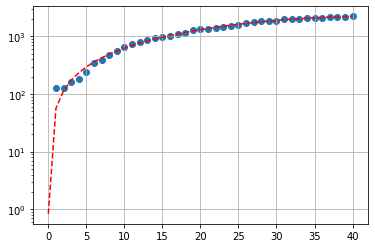

In [64]:
calculate_and_create_chart_for_province(START_DATE, 'Lodi')

## Mantova

Total cases per 1000 inhabitants up to today: 4.8011
Total cases up to today: 1981
New cases registered today: 97
New cases registered today in %: 5.15
Doubling time in the last five days: 17.1
Doubling time yesterday: 17.8
Trend of new cases (in %) in the last 5 days: 22.51


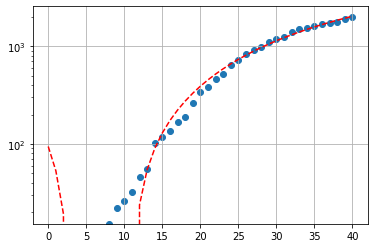

In [65]:
calculate_and_create_chart_for_province(START_DATE, 'Mantova')

## Milano

Total cases per 1000 inhabitants up to today: 3.3618
Total cases up to today: 10819
New cases registered today: 428
New cases registered today in %: 4.12
Doubling time in the last five days: 15.7
Doubling time yesterday: 15.7
Trend of new cases (in %) in the last 5 days: 24.7


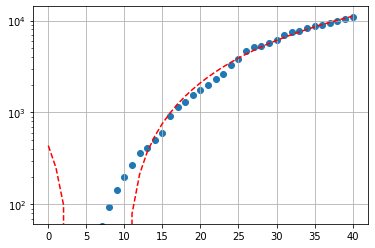

In [66]:
calculate_and_create_chart_for_province(START_DATE, 'Milano')

## Monza e della Brianza

Total cases per 1000 inhabitants up to today: 3.378
Total cases up to today: 2935
New cases registered today: 161
New cases registered today in %: 5.8
Doubling time in the last five days: 16.0
Doubling time yesterday: 17.1
Trend of new cases (in %) in the last 5 days: 24.26


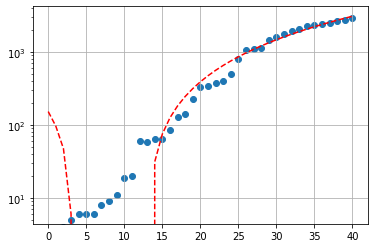

In [67]:
calculate_and_create_chart_for_province(START_DATE, 'Monza e della Brianza')

## Pavia

Total cases per 1000 inhabitants up to today: 4.5665
Total cases up to today: 2499
New cases registered today: 168
New cases registered today in %: 7.21
Doubling time in the last five days: 16.9
Doubling time yesterday: 20.8
Trend of new cases (in %) in the last 5 days: 22.74


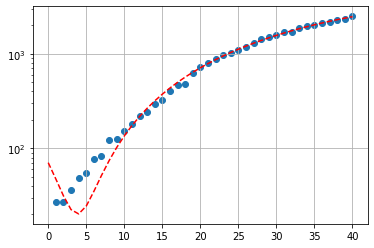

In [68]:
calculate_and_create_chart_for_province(START_DATE, 'Pavia')

## Sondrio

Total cases per 1000 inhabitants up to today: 3.103
Total cases up to today: 563
New cases registered today: 26
New cases registered today in %: 4.84
Doubling time in the last five days: 14.9
Doubling time yesterday: 14.4
Trend of new cases (in %) in the last 5 days: 26.23


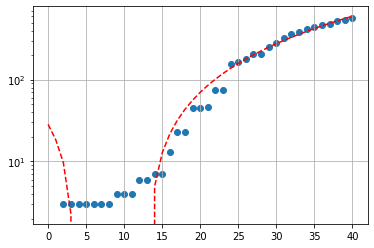

In [69]:
calculate_and_create_chart_for_province(START_DATE, 'Sondrio')

## Varese

Total cases per 1000 inhabitants up to today: 1.2898
Total cases up to today: 1148
New cases registered today: 63
New cases registered today in %: 5.81
Doubling time in the last five days: 12.3
Doubling time yesterday: 12.0
Trend of new cases (in %) in the last 5 days: 32.56


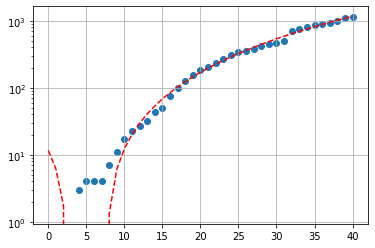

In [70]:
calculate_and_create_chart_for_province(START_DATE, 'Varese')

# Casi di COVID-19 nelle Marche - COVID-19 cases in Marche

Total cases up to today: 4246
New cases registered today: 106
New cases registered today in %: 2.56
Doubling time in the last five days: 21.7
Doubling time yesterday: 20.5
Trend of new cases (in %) in the last 5 days: 17.33


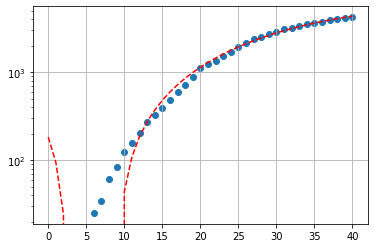

In [71]:
calculate_and_create_chart_for_region(START_DATE, 'Marche')

## Ancona

Total cases per 1000 inhabitants up to today: 2.7208
Total cases up to today: 1290
New cases registered today: 27
New cases registered today in %: 2.14
Doubling time in the last five days: 17.6
Doubling time yesterday: 16.1
Trend of new cases (in %) in the last 5 days: 21.7


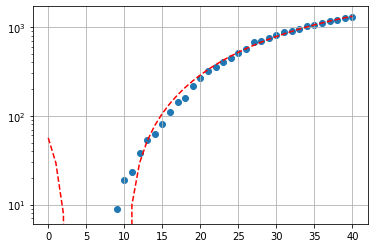

In [72]:
calculate_and_create_chart_for_province(START_DATE, 'Ancona')

## Ascoli Piceno

Total cases per 1000 inhabitants up to today: 1.1124
Total cases up to today: 233
New cases registered today: 1
New cases registered today in %: 0.43
Doubling time in the last five days: 20.6
Doubling time yesterday: 13.4
Trend of new cases (in %) in the last 5 days: 18.27


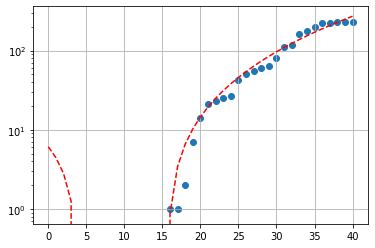

In [73]:
calculate_and_create_chart_for_province(START_DATE, 'Ascoli Piceno')

## Fermo

Total cases per 1000 inhabitants up to today: 1.7444
Total cases up to today: 305
New cases registered today: 7
New cases registered today in %: 2.35
Doubling time in the last five days: 16.1
Doubling time yesterday: 18.1
Trend of new cases (in %) in the last 5 days: 23.98


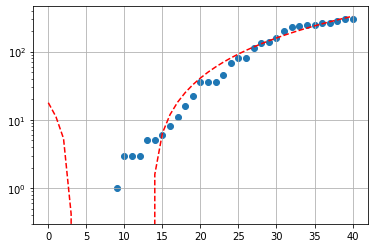

In [74]:
calculate_and_create_chart_for_province(START_DATE, 'Fermo')

## Macerata

Total cases per 1000 inhabitants up to today: 1.8751
Total cases up to today: 598
New cases registered today: 37
New cases registered today in %: 6.6
Doubling time in the last five days: 15.3
Doubling time yesterday: 21.1
Trend of new cases (in %) in the last 5 days: 25.37


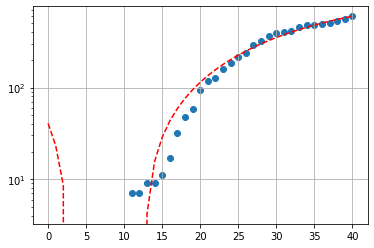

In [75]:
calculate_and_create_chart_for_province(START_DATE, 'Macerata')

## Pesaro e Urbino

Total cases per 1000 inhabitants up to today: 5.0456
Total cases up to today: 1820
New cases registered today: 34
New cases registered today in %: 1.9
Doubling time in the last five days: 33.1
Doubling time yesterday: 27.8
Trend of new cases (in %) in the last 5 days: 11.04


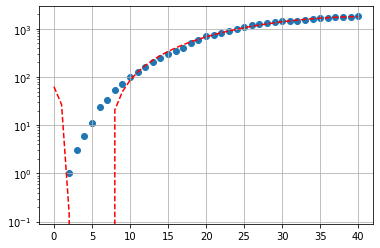

In [76]:
calculate_and_create_chart_for_province(START_DATE, 'Pesaro e Urbino')

# Casi di COVID-19 in Molise - COVID-19 cases in Molise¶

Total cases up to today: 194
New cases registered today: 30
New cases registered today in %: 18.29
Doubling time in the last five days: 7.6
Doubling time yesterday: 10.3
Trend of new cases (in %) in the last 5 days: 57.72


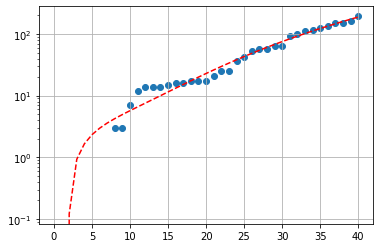

In [77]:
calculate_and_create_chart_for_region(START_DATE, 'Molise')

## Campobasso

Total cases per 1000 inhabitants up to today: 0.6855
Total cases up to today: 154
New cases registered today: 5
New cases registered today in %: 3.36
Doubling time in the last five days: 11.5
Doubling time yesterday: 10.8
Trend of new cases (in %) in the last 5 days: 35.09


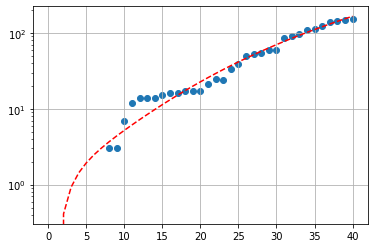

In [78]:
calculate_and_create_chart_for_province(START_DATE, 'Campobasso')

## Isernia

Total cases per 1000 inhabitants up to today: 0.4662
Total cases up to today: 40
New cases registered today: 25
New cases registered today in %: 166.67
Doubling time in the last five days: 2.3
Doubling time yesterday: 6.8
Trend of new cases (in %) in the last 5 days: 344.44


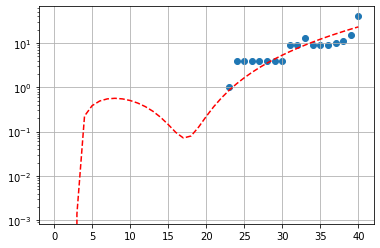

In [79]:
calculate_and_create_chart_for_province(START_DATE, 'Isernia')

# Casi di COVID-19 in Piemonte - COVID-19 cases in Piedmont 

Total cases up to today: 11499
New cases registered today: 798
New cases registered today in %: 7.46
Doubling time in the last five days: 11.5
Doubling time yesterday: 12.0
Trend of new cases (in %) in the last 5 days: 35.11


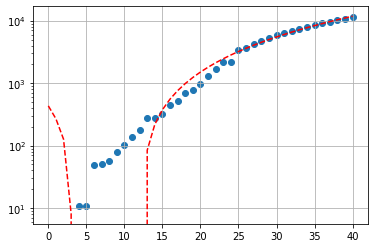

In [80]:
calculate_and_create_chart_for_region(START_DATE, 'Piemonte')

## Alessandria

Total cases per 1000 inhabitants up to today: 3.729
Total cases up to today: 1591
New cases registered today: 100
New cases registered today in %: 6.71
Doubling time in the last five days: 15.9
Doubling time yesterday: 20.1
Trend of new cases (in %) in the last 5 days: 24.3


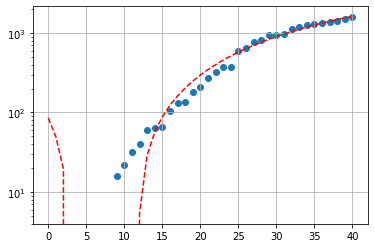

In [81]:
calculate_and_create_chart_for_province(START_DATE, 'Alessandria')

## Asti

Total cases per 1000 inhabitants up to today: 2.5845
Total cases up to today: 560
New cases registered today: 37
New cases registered today in %: 7.07
Doubling time in the last five days: 10.5
Doubling time yesterday: 7.4
Trend of new cases (in %) in the last 5 days: 39.3


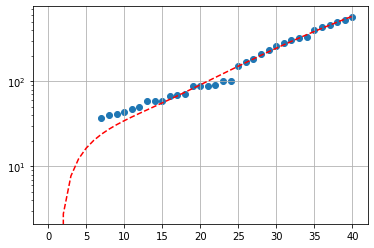

In [82]:
calculate_and_create_chart_for_province(START_DATE, 'Asti')

## Biella

Total cases per 1000 inhabitants up to today: 3.1308
Total cases up to today: 559
New cases registered today: 17
New cases registered today in %: 3.14
Doubling time in the last five days: 20.2
Doubling time yesterday: 16.4
Trend of new cases (in %) in the last 5 days: 18.68


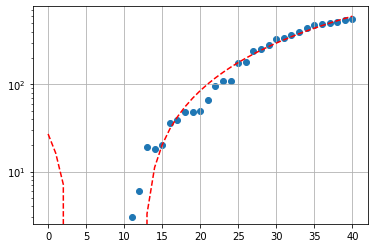

In [83]:
calculate_and_create_chart_for_province(START_DATE, 'Biella')

## Cuneo

Total cases per 1000 inhabitants up to today: 1.5821
Total cases up to today: 932
New cases registered today: 82
New cases registered today in %: 9.65
Doubling time in the last five days: 9.6
Doubling time yesterday: 9.5
Trend of new cases (in %) in the last 5 days: 43.38


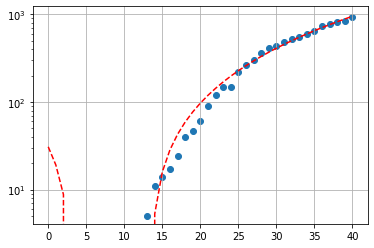

In [84]:
calculate_and_create_chart_for_province(START_DATE, 'Cuneo')

## Novara

Total cases per 1000 inhabitants up to today: 2.6125
Total cases up to today: 967
New cases registered today: 37
New cases registered today in %: 3.98
Doubling time in the last five days: 12.5
Doubling time yesterday: 11.8
Trend of new cases (in %) in the last 5 days: 31.92


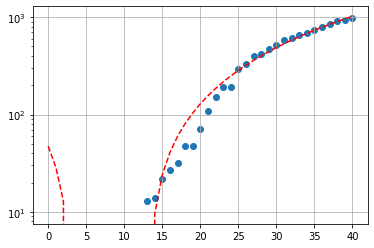

In [85]:
calculate_and_create_chart_for_province(START_DATE, 'Novara')

## Torino

Total cases per 1000 inhabitants up to today: 2.534
Total cases up to today: 5772
New cases registered today: 477
New cases registered today in %: 9.01
Doubling time in the last five days: 10.5
Doubling time yesterday: 11.7
Trend of new cases (in %) in the last 5 days: 39.08


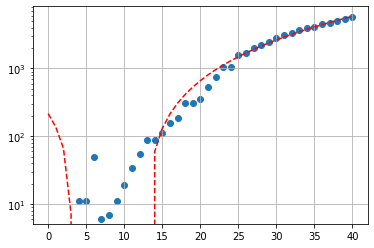

In [86]:
calculate_and_create_chart_for_province(START_DATE, 'Torino')

## 	Verbano-Cusio-Ossola

Total cases per 1000 inhabitants up to today: 3.3508
Total cases up to today: 535
New cases registered today: 30
New cases registered today in %: 5.94
Doubling time in the last five days: 9.8
Doubling time yesterday: 9.2
Trend of new cases (in %) in the last 5 days: 42.29


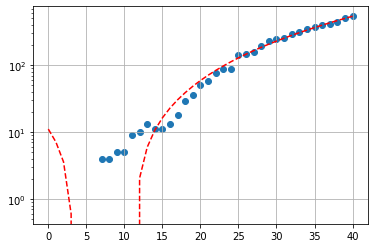

In [87]:
calculate_and_create_chart_for_province(START_DATE, 'Verbano-Cusio-Ossola')

## Vercelli

Total cases per 1000 inhabitants up to today: 3.3531
Total cases up to today: 583
New cases registered today: 18
New cases registered today in %: 3.19
Doubling time in the last five days: 13.3
Doubling time yesterday: 12.3
Trend of new cases (in %) in the last 5 days: 29.84


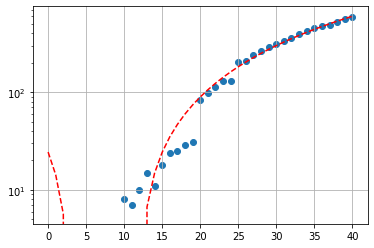

In [88]:
calculate_and_create_chart_for_province(START_DATE, 'Vercelli')

# Casi di COVID-19 in Puglia - COVID-19 cases in Apulia

Total cases up to today: 2213
New cases registered today: 61
New cases registered today in %: 2.83
Doubling time in the last five days: 12.6
Doubling time yesterday: 9.3
Trend of new cases (in %) in the last 5 days: 31.73


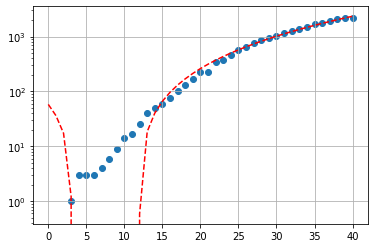

In [89]:
calculate_and_create_chart_for_region(START_DATE, 'Puglia')

## Bari

Total cases per 1000 inhabitants up to today: 0.6047
Total cases up to today: 762
New cases registered today: 21
New cases registered today in %: 2.83
Doubling time in the last five days: 13.9
Doubling time yesterday: 9.7
Trend of new cases (in %) in the last 5 days: 28.28


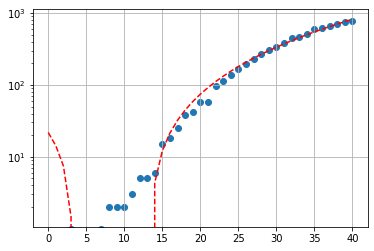

In [90]:
calculate_and_create_chart_for_province(START_DATE, 'Bari')

## 	Barletta-Andria-Trani

Total cases per 1000 inhabitants up to today: 0.3286
Total cases up to today: 129
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 15.4
Doubling time yesterday: 12.6
Trend of new cases (in %) in the last 5 days: 25.24


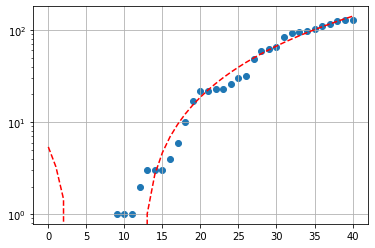

In [91]:
calculate_and_create_chart_for_province(START_DATE, 'Barletta-Andria-Trani')

## Brindisi

Total cases per 1000 inhabitants up to today: 0.5893
Total cases up to today: 234
New cases registered today: 16
New cases registered today in %: 7.34
Doubling time in the last five days: 9.8
Doubling time yesterday: 9.6
Trend of new cases (in %) in the last 5 days: 42.68


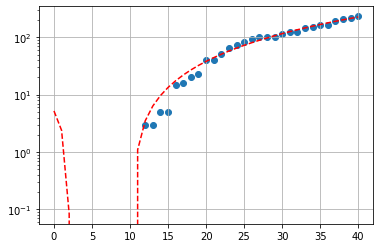

In [92]:
calculate_and_create_chart_for_province(START_DATE, 'Brindisi')

## Foggia

Total cases per 1000 inhabitants up to today: 0.8687
Total cases up to today: 546
New cases registered today: 19
New cases registered today in %: 3.61
Doubling time in the last five days: 11.6
Doubling time yesterday: 10.3
Trend of new cases (in %) in the last 5 days: 34.81


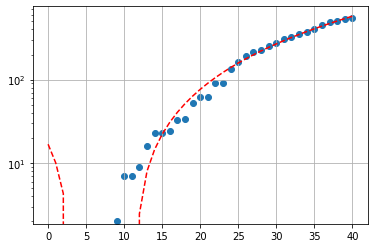

In [93]:
calculate_and_create_chart_for_province(START_DATE, 'Foggia')

## Lecce

Total cases per 1000 inhabitants up to today: 0.4513
Total cases up to today: 362
New cases registered today: 3
New cases registered today in %: 0.84
Doubling time in the last five days: 16.4
Doubling time yesterday: 8.5
Trend of new cases (in %) in the last 5 days: 23.55


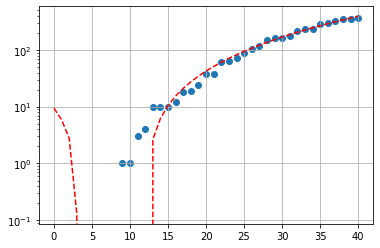

In [94]:
calculate_and_create_chart_for_province(START_DATE, 'Lecce')

## Taranto

Total cases per 1000 inhabitants up to today: 0.3085
Total cases up to today: 180
New cases registered today: 2
New cases registered today in %: 1.12
Doubling time in the last five days: 8.7
Doubling time yesterday: 5.9
Trend of new cases (in %) in the last 5 days: 48.76


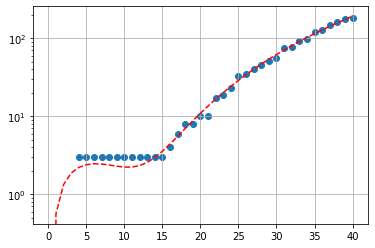

In [95]:
calculate_and_create_chart_for_province(START_DATE, 'Taranto')

# Casi di COVID-19 in Sardegna - COVID-19 cases in Sardinia

Total cases up to today: 874
New cases registered today: 49
New cases registered today in %: 5.94
Doubling time in the last five days: 14.0
Doubling time yesterday: 13.5
Trend of new cases (in %) in the last 5 days: 28.15


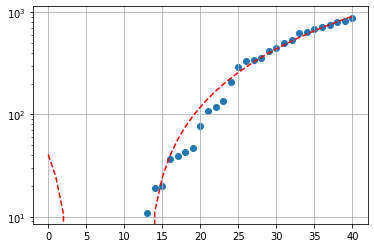

In [96]:
calculate_and_create_chart_for_region(START_DATE, 'Sardegna')

## Cagliari

Total cases per 1000 inhabitants up to today: 0.257
Total cases up to today: 144
New cases registered today: 10
New cases registered today in %: 7.46
Doubling time in the last five days: 10.3
Doubling time yesterday: 12.7
Trend of new cases (in %) in the last 5 days: 39.81


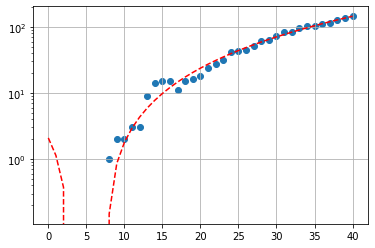

In [97]:
calculate_and_create_chart_for_province(START_DATE, 'Cagliari')

## Nuoro

Total cases per 1000 inhabitants up to today: 0.3972
Total cases up to today: 62
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 41.2
Doubling time yesterday: 41.2
Trend of new cases (in %) in the last 5 days: 8.77


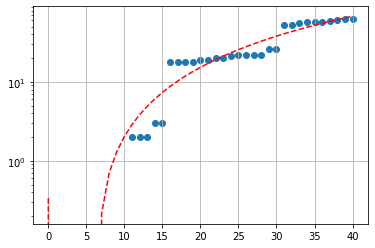

In [98]:
calculate_and_create_chart_for_province(START_DATE, 'Nuoro')

## Oristano

Total cases per 1000 inhabitants up to today: 0.1244
Total cases up to today: 20
New cases registered today: 1
New cases registered today in %: 5.26
Doubling time in the last five days: 5.0
Doubling time yesterday: 4.6
Trend of new cases (in %) in the last 5 days: 100.0


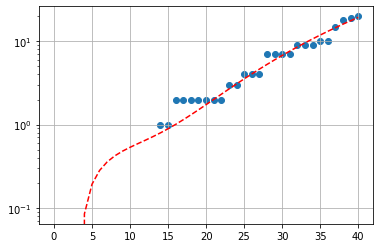

In [99]:
calculate_and_create_chart_for_province(START_DATE, 'Oristano')

## Sassari

Total cases per 1000 inhabitants up to today: 1.7561
Total cases up to today: 585
New cases registered today: 38
New cases registered today in %: 6.95
Doubling time in the last five days: 13.7
Doubling time yesterday: 12.5
Trend of new cases (in %) in the last 5 days: 28.85


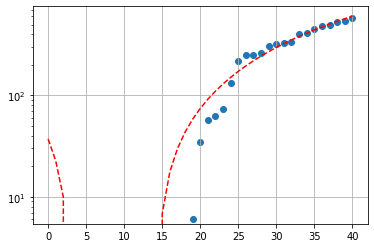

In [100]:
calculate_and_create_chart_for_province(START_DATE, 'Sassari')

# Casi di COVID-19 in Sicilia - COVID-19 cases in Sicily

Total cases up to today: 1932
New cases registered today: 73
New cases registered today in %: 3.93
Doubling time in the last five days: 16.0
Doubling time yesterday: 14.3
Trend of new cases (in %) in the last 5 days: 24.24


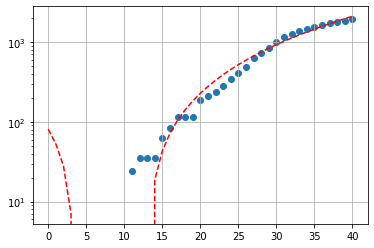

In [101]:
calculate_and_create_chart_for_region(START_DATE, 'Sicilia')

## Agrigento

Total cases per 1000 inhabitants up to today: 0.2307
Total cases up to today: 102
New cases registered today: 2
New cases registered today in %: 2.0
Doubling time in the last five days: 25.4
Doubling time yesterday: 13.9
Trend of new cases (in %) in the last 5 days: 14.61


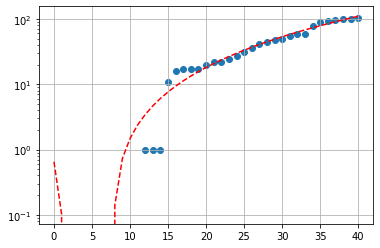

In [102]:
calculate_and_create_chart_for_province(START_DATE, 'Agrigento')

## Caltanissetta

Total cases per 1000 inhabitants up to today: 0.3448
Total cases up to today: 93
New cases registered today: 10
New cases registered today in %: 12.05
Doubling time in the last five days: 12.2
Doubling time yesterday: 17.4
Trend of new cases (in %) in the last 5 days: 32.86


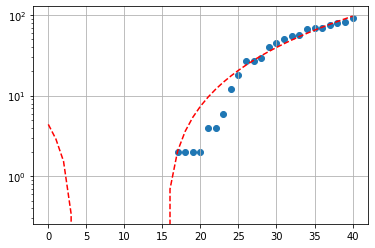

In [103]:
calculate_and_create_chart_for_province(START_DATE, 'Caltanissetta')

## Catania

Total cases per 1000 inhabitants up to today: 0.5111
Total cases up to today: 569
New cases registered today: 10
New cases registered today in %: 1.79
Doubling time in the last five days: 14.5
Doubling time yesterday: 10.9
Trend of new cases (in %) in the last 5 days: 27.01


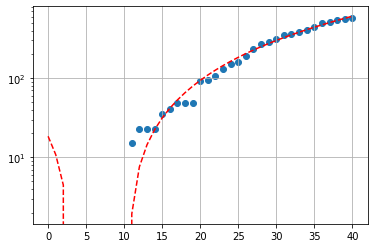

In [104]:
calculate_and_create_chart_for_province(START_DATE, 'Catania')

## Enna

Total cases per 1000 inhabitants up to today: 1.6662
Total cases up to today: 280
New cases registered today: 23
New cases registered today in %: 8.95
Doubling time in the last five days: 9.6
Doubling time yesterday: 11.9
Trend of new cases (in %) in the last 5 days: 43.59


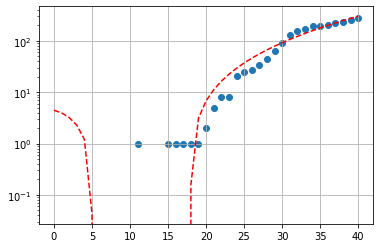

In [105]:
calculate_and_create_chart_for_province(START_DATE, 'Enna')

## Messina

Total cases per 1000 inhabitants up to today: 0.5403
Total cases up to today: 344
New cases registered today: 7
New cases registered today in %: 2.08
Doubling time in the last five days: 28.8
Doubling time yesterday: 22.6
Trend of new cases (in %) in the last 5 days: 12.79


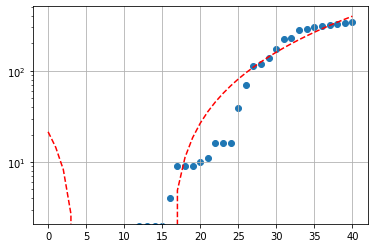

In [106]:
calculate_and_create_chart_for_province(START_DATE, 'Messina')

## Palermo

Total cases per 1000 inhabitants up to today: 0.2334
Total cases up to today: 296
New cases registered today: 6
New cases registered today in %: 2.07
Doubling time in the last five days: 22.1
Doubling time yesterday: 16.8
Trend of new cases (in %) in the last 5 days: 17.0


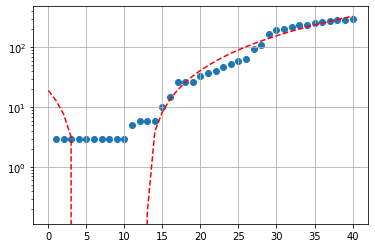

In [107]:
calculate_and_create_chart_for_province(START_DATE, 'Palermo')

## Ragusa

Total cases per 1000 inhabitants up to today: 0.1463
Total cases up to today: 47
New cases registered today: 1
New cases registered today in %: 2.17
Doubling time in the last five days: 11.8
Doubling time yesterday: 9.5
Trend of new cases (in %) in the last 5 days: 34.29


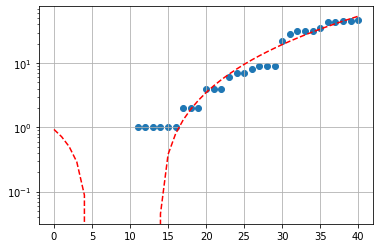

In [108]:
calculate_and_create_chart_for_province(START_DATE, 'Ragusa')

## Siracusa

Total cases per 1000 inhabitants up to today: 0.2656
Total cases up to today: 107
New cases registered today: 1
New cases registered today in %: 0.94
Doubling time in the last five days: 18.8
Doubling time yesterday: 17.5
Trend of new cases (in %) in the last 5 days: 20.22


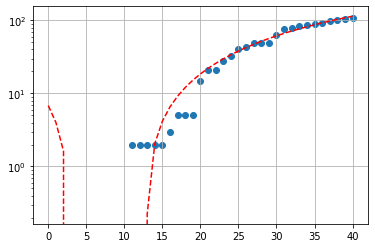

In [109]:
calculate_and_create_chart_for_province(START_DATE, 'Siracusa')

## Trapani

Total cases per 1000 inhabitants up to today: 0.2164
Total cases up to today: 94
New cases registered today: 13
New cases registered today in %: 16.05
Doubling time in the last five days: 12.4
Doubling time yesterday: 26.3
Trend of new cases (in %) in the last 5 days: 32.39


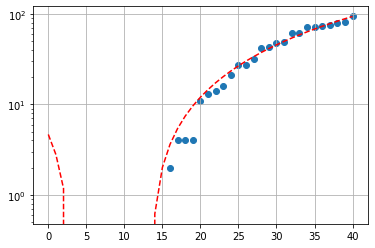

In [110]:
calculate_and_create_chart_for_province(START_DATE, 'Trapani')

# Casi di COVID-19 in Toscana - COVID-19 cases in Tuscany

Total cases up to today: 5671
New cases registered today: 172
New cases registered today in %: 3.13
Doubling time in the last five days: 13.8
Doubling time yesterday: 12.0
Trend of new cases (in %) in the last 5 days: 28.54


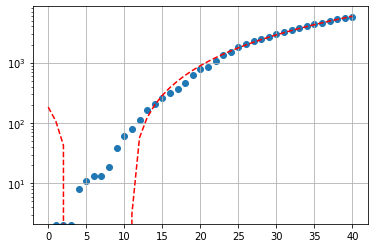

In [111]:
calculate_and_create_chart_for_region(START_DATE, 'Toscana')

## Arezzo

Total cases per 1000 inhabitants up to today: 1.0744
Total cases up to today: 370
New cases registered today: 12
New cases registered today in %: 3.35
Doubling time in the last five days: 19.6
Doubling time yesterday: 15.0
Trend of new cases (in %) in the last 5 days: 19.35


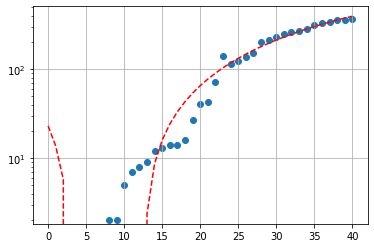

In [112]:
calculate_and_create_chart_for_province(START_DATE, 'Arezzo')

## Firenze

Total cases per 1000 inhabitants up to today: 1.6029
Total cases up to today: 1626
New cases registered today: 83
New cases registered today in %: 5.38
Doubling time in the last five days: 7.5
Doubling time yesterday: 7.3
Trend of new cases (in %) in the last 5 days: 59.1


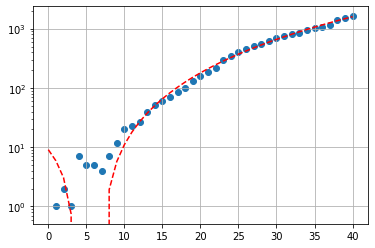

In [113]:
calculate_and_create_chart_for_province(START_DATE, 'Firenze')

## Grosseto

Total cases per 1000 inhabitants up to today: 1.224
Total cases up to today: 273
New cases registered today: 9
New cases registered today in %: 3.41
Doubling time in the last five days: 41.2
Doubling time yesterday: 46.4
Trend of new cases (in %) in the last 5 days: 8.76


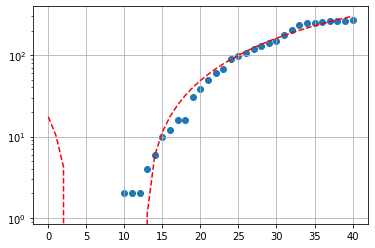

In [114]:
calculate_and_create_chart_for_province(START_DATE, 'Grosseto')

## Livorno

Total cases per 1000 inhabitants up to today: 0.9368
Total cases up to today: 316
New cases registered today: 9
New cases registered today in %: 2.93
Doubling time in the last five days: 22.6
Doubling time yesterday: 13.2
Trend of new cases (in %) in the last 5 days: 16.61


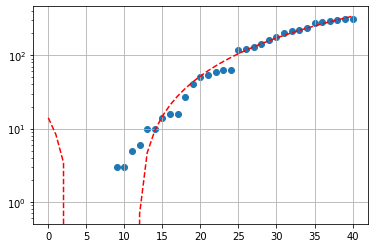

In [115]:
calculate_and_create_chart_for_province(START_DATE, 'Livorno')

## Lucca

Total cases per 1000 inhabitants up to today: 2.1921
Total cases up to today: 855
New cases registered today: 12
New cases registered today in %: 1.42
Doubling time in the last five days: 18.8
Doubling time yesterday: 15.3
Trend of new cases (in %) in the last 5 days: 20.25


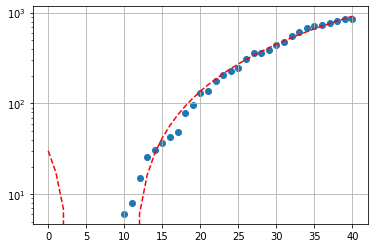

In [116]:
calculate_and_create_chart_for_province(START_DATE, 'Lucca')

## Massa Carrara

Total cases per 1000 inhabitants up to today: 3.3523
Total cases up to today: 659
New cases registered today: 15
New cases registered today in %: 2.33
Doubling time in the last five days: 17.9
Doubling time yesterday: 13.0
Trend of new cases (in %) in the last 5 days: 21.36


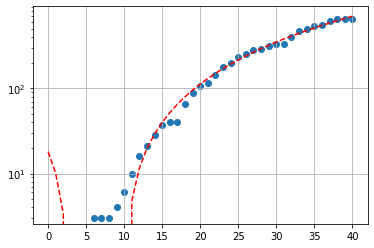

In [117]:
calculate_and_create_chart_for_province(START_DATE, 'Massa Carrara')

## Pisa

Total cases per 1000 inhabitants up to today: 1.2493
Total cases up to today: 527
New cases registered today: 8
New cases registered today in %: 1.54
Doubling time in the last five days: 20.8
Doubling time yesterday: 18.9
Trend of new cases (in %) in the last 5 days: 18.16


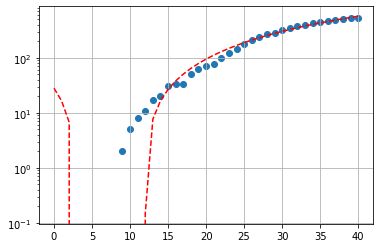

In [118]:
calculate_and_create_chart_for_province(START_DATE, 'Pisa')

## Pistoia

Total cases per 1000 inhabitants up to today: 1.2815
Total cases up to today: 374
New cases registered today: 13
New cases registered today in %: 3.6
Doubling time in the last five days: 24.1
Doubling time yesterday: 22.3
Trend of new cases (in %) in the last 5 days: 15.43


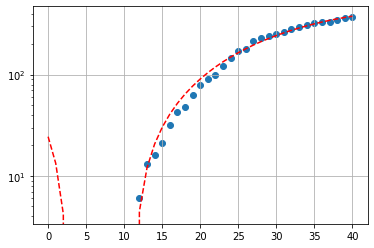

In [119]:
calculate_and_create_chart_for_province(START_DATE, 'Pistoia')

## Prato

Total cases per 1000 inhabitants up to today: 1.304
Total cases up to today: 332
New cases registered today: 9
New cases registered today in %: 2.79
Doubling time in the last five days: 11.9
Doubling time yesterday: 9.1
Trend of new cases (in %) in the last 5 days: 33.87


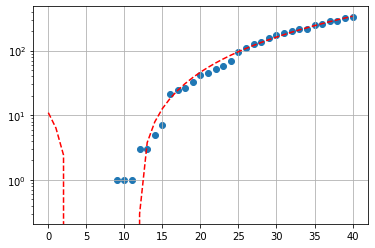

In [120]:
calculate_and_create_chart_for_province(START_DATE, 'Prato')

## Siena

Total cases per 1000 inhabitants up to today: 1.2633
Total cases up to today: 339
New cases registered today: 2
New cases registered today in %: 0.59
Doubling time in the last five days: 20.4
Doubling time yesterday: 16.5
Trend of new cases (in %) in the last 5 days: 18.53


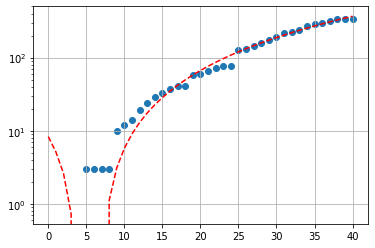

In [121]:
calculate_and_create_chart_for_province(START_DATE, 'Siena')

# Casi di COVID-19 in Provincia Autonoma di Trento - COVID-19 cases in the Autonomous Province of Trento

Total cases per 1000 inhabitants up to today: 4.1218
Total cases up to today: 2220
New cases registered today: 111
New cases registered today in %: 5.26
Doubling time in the last five days: 12.5
Doubling time yesterday: 12.4
Trend of new cases (in %) in the last 5 days: 31.99


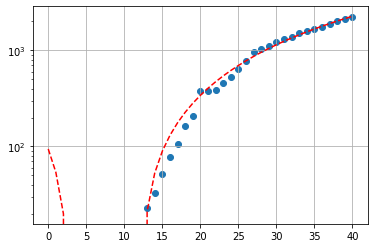

In [122]:
calculate_and_create_chart_for_province(START_DATE, 'Trento')

# Casi di COVID-19 in Umbria - COVID-19 cases in Umbria

Total cases up to today: 1168
New cases registered today: 27
New cases registered today in %: 2.37
Doubling time in the last five days: 25.2
Doubling time yesterday: 24.9
Trend of new cases (in %) in the last 5 days: 14.73


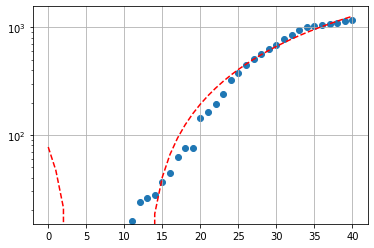

In [123]:
calculate_and_create_chart_for_region(START_DATE, 'Umbria')

## Perugia

Total cases per 1000 inhabitants up to today: 1.3698
Total cases up to today: 905
New cases registered today: 21
New cases registered today in %: 2.38
Doubling time in the last five days: 26.0
Doubling time yesterday: 26.3
Trend of new cases (in %) in the last 5 days: 14.27


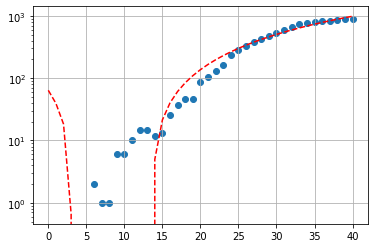

In [124]:
calculate_and_create_chart_for_province(START_DATE, 'Perugia')

## Terni

Total cases per 1000 inhabitants up to today: 1.1524
Total cases up to today: 263
New cases registered today: 6
New cases registered today in %: 2.33
Doubling time in the last five days: 22.9
Doubling time yesterday: 21.1
Trend of new cases (in %) in the last 5 days: 16.37


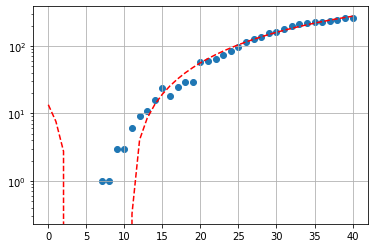

In [125]:
calculate_and_create_chart_for_province(START_DATE, 'Terni')

# Casi di COVID-19 in Valle d'Aosta - COVID-19 cases in Aosta Valley

Total cases per 1000 inhabitants up to today: 5.8952
Total cases up to today: 748
New cases registered today: 29
New cases registered today in %: 4.03
Doubling time in the last five days: 14.0
Doubling time yesterday: 16.7
Trend of new cases (in %) in the last 5 days: 28.08


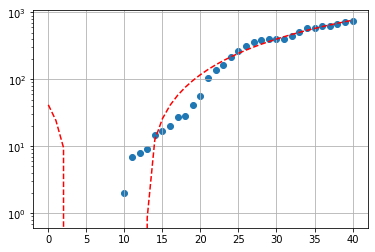

In [126]:
calculate_and_create_chart_for_province(START_DATE, "Aosta")

# Casi di COVID-19 in Veneto - COVID-19 cases in Veneto

Total cases up to today: 10542
New cases registered today: 330
New cases registered today in %: 3.23
Doubling time in the last five days: 15.7
Doubling time yesterday: 14.9
Trend of new cases (in %) in the last 5 days: 24.79


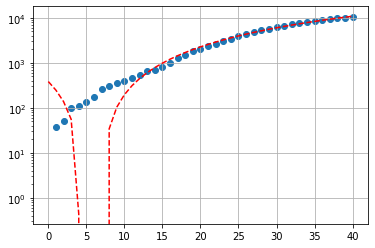

In [127]:
calculate_and_create_chart_for_region(START_DATE, 'Veneto')

## Belluno

Total cases per 1000 inhabitants up to today: 2.5367
Total cases up to today: 522
New cases registered today: 23
New cases registered today in %: 4.61
Doubling time in the last five days: 16.5
Doubling time yesterday: 15.0
Trend of new cases (in %) in the last 5 days: 23.4


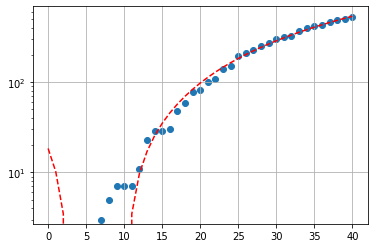

In [128]:
calculate_and_create_chart_for_province(START_DATE, 'Belluno')

## Padova

Total cases per 1000 inhabitants up to today: 2.8111
Total cases up to today: 2632
New cases registered today: 79
New cases registered today in %: 3.09
Doubling time in the last five days: 18.8
Doubling time yesterday: 18.8
Trend of new cases (in %) in the last 5 days: 20.29


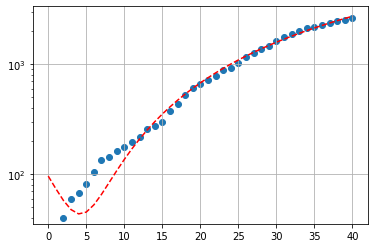

In [129]:
calculate_and_create_chart_for_province(START_DATE, 'Padova')

## Rovigo

Total cases per 1000 inhabitants up to today: 0.7712
Total cases up to today: 184
New cases registered today: 4
New cases registered today in %: 2.22
Doubling time in the last five days: 10.2
Doubling time yesterday: 9.5
Trend of new cases (in %) in the last 5 days: 40.46


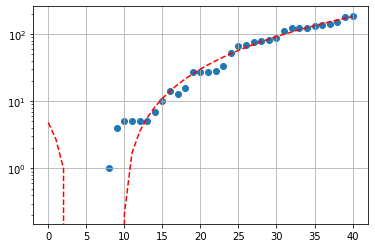

In [130]:
calculate_and_create_chart_for_province(START_DATE, 'Rovigo')

## Treviso

Total cases per 1000 inhabitants up to today: 1.9041
Total cases up to today: 1687
New cases registered today: 30
New cases registered today in %: 1.81
Doubling time in the last five days: 22.8
Doubling time yesterday: 20.7
Trend of new cases (in %) in the last 5 days: 16.43


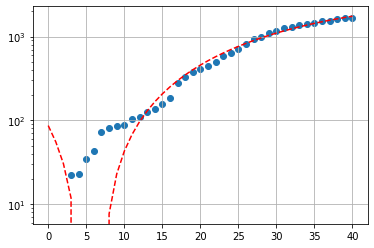

In [131]:
calculate_and_create_chart_for_province(START_DATE, 'Treviso')

## Venezia

Total cases per 1000 inhabitants up to today: 1.5943
Total cases up to today: 1362
New cases registered today: 41
New cases registered today in %: 3.1
Doubling time in the last five days: 16.7
Doubling time yesterday: 16.2
Trend of new cases (in %) in the last 5 days: 23.04


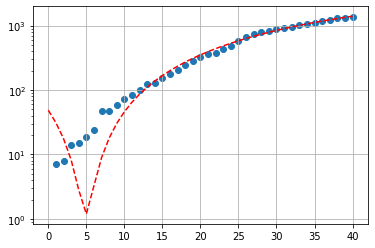

In [132]:
calculate_and_create_chart_for_province(START_DATE, 'Venezia')

## Verona

Total cases per 1000 inhabitants up to today: 2.7638
Total cases up to today: 2547
New cases registered today: 59
New cases registered today in %: 2.37
Doubling time in the last five days: 13.8
Doubling time yesterday: 12.3
Trend of new cases (in %) in the last 5 days: 28.51


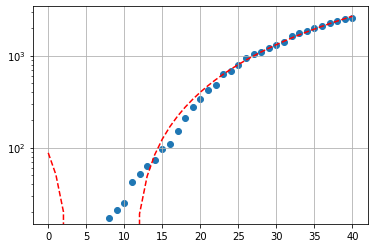

In [133]:
calculate_and_create_chart_for_province(START_DATE, 'Verona')

## Vicenza

Total cases per 1000 inhabitants up to today: 1.8588
Total cases up to today: 1608
New cases registered today: 94
New cases registered today in %: 6.21
Doubling time in the last five days: 10.8
Doubling time yesterday: 11.0
Trend of new cases (in %) in the last 5 days: 37.67


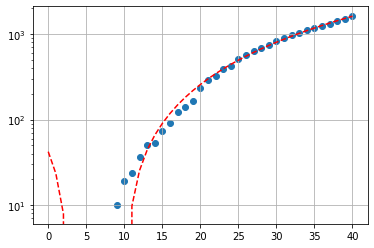

In [134]:
calculate_and_create_chart_for_province(START_DATE, 'Vicenza')